# Hand-in 3, Part 1: Data handling and exploration

In this first notebook you will show us how you handle data being separated over several files, as well as exploring the quality and properties of your data.

#### Section 1: bash scripting

You have downloaded a zip file containing 5 CSV files, each containing part of the data you need. First, use your bash tools to look at the headers and size of the file. What do the different files contain?

Write a bash script that concatenates the 4 data files (except the flow_criticality_data.csv file). Exlain in the markdown cell below, what each part of your script does.

**Q#1** *Explain your script here (by double clicking on this text).*

* Define that we are using bash
```bash
#! /bin/bash
```

* Quick explanation of what the bashscript does
```bash
# Joining the files
#
# Usage "./collect_data.sh 
```
* Make temp1.csv containing half the data -t, means the file is comma seperated, -a1 and -a2 means that it will also print any unpairable line -oauto means that it will automatically format the data
```bash
join -t, -a1 -a2 -oauto energy_demand_data.csv exchange_data.csv > temp1.csv
```
* Make temp2.csv containing the other half of data
```bash
join -t, -a1 -a2 -oauto renewable_production_data.csv generator_production_data.csv > temp2.csv
```
* Combine the temp files, to one whole file
```bash
join -t, -a1 -a2 -oauto temp1.csv temp2.csv > joined_data.csv
```
* Clean up by removing the temp files
```bash
rm temp1.csv
rm temp2.csv
```


## Section 2: Visualizing the data
Here you will plot the resulting data file from the previous section, and plot it in order to identify missing data and see if you can already draw some conclusions on the data.

* *Hint: remember the hint given in Exc.13.3, on how to find out if your data contains NaN values*

In [1]:
# Importing the packages we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
import numpy as np
import scipy

/home/student/.local/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
# Import of the data created with the bash script
data  = pd.read_csv('joined_data.csv')

<IPython.core.display.Javascript object>


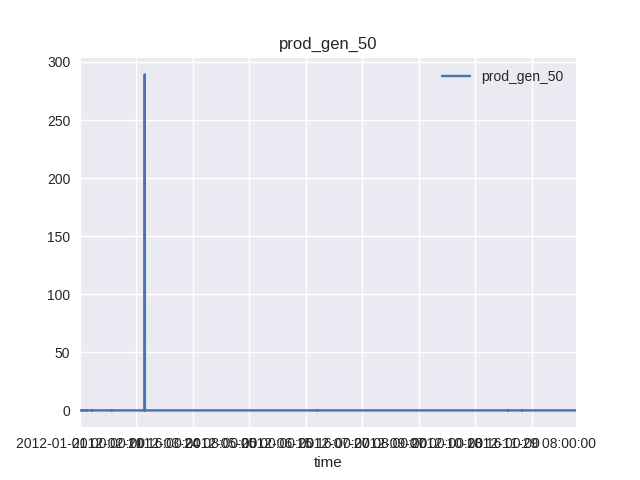

/home/student/.local/lib/python3.5/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


<IPython.core.display.Javascript object>


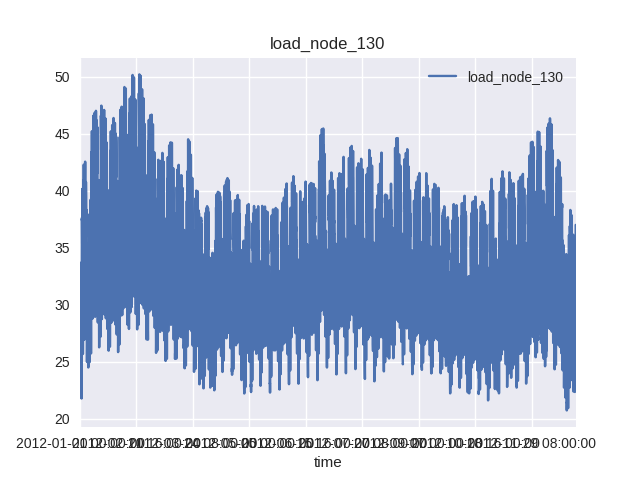

<IPython.core.display.Javascript object>


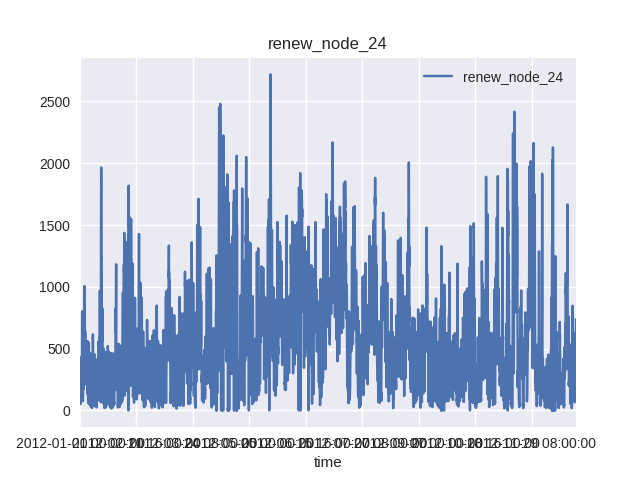

In [16]:
# Simple plots showing a small pick of our data

data.plot(x='time',y='prod_gen_50',title='prod_gen_50')
data.plot(x='time',y='load_node_130',title='load_node_130')
data.plot(x='time',y='renew_node_24',title='renew_node_24')



**would it be practical to plot all possible scatter plots (scatter matrix)?**

*Not really, unless you use a cluster to compute the data, as there are way too many datapoints and columns*

**Q#2** For this data, what is the reasonable approach to dealing with the NaN values? Why?

*As there appears to be only small sample times missing, we use interpolation to remove the NaN's*


In [4]:
# Removal of NaN's


print("Total number of NaN's before removal: " +str(data.isnull().sum().sum()))
# Drop any row containing any NaN's
data_nona = data.interpolate('linear')
print("Total number of NaN's after removal: " +str(data_nona.isnull().sum().sum()))

Total number of NaN's before removal: 1711
Total number of NaN's after removal: 0


### Feature reduction
Since you must reduce the amount of sensors, you need to find out which ones you can get rid of. 

**Q#3** Why would PCA be useful for this?

*It shows you which components are principal for your data. Thereby showing which sensors are impacting the overall data more*

*With that in mind, you can narrow down the amount of sensors, used to generate data. Obviously you will loose some data, but choosing the correct amount of components, you can get pretty close to the full data*

NaN's in data set: 0


<IPython.core.display.Javascript object>


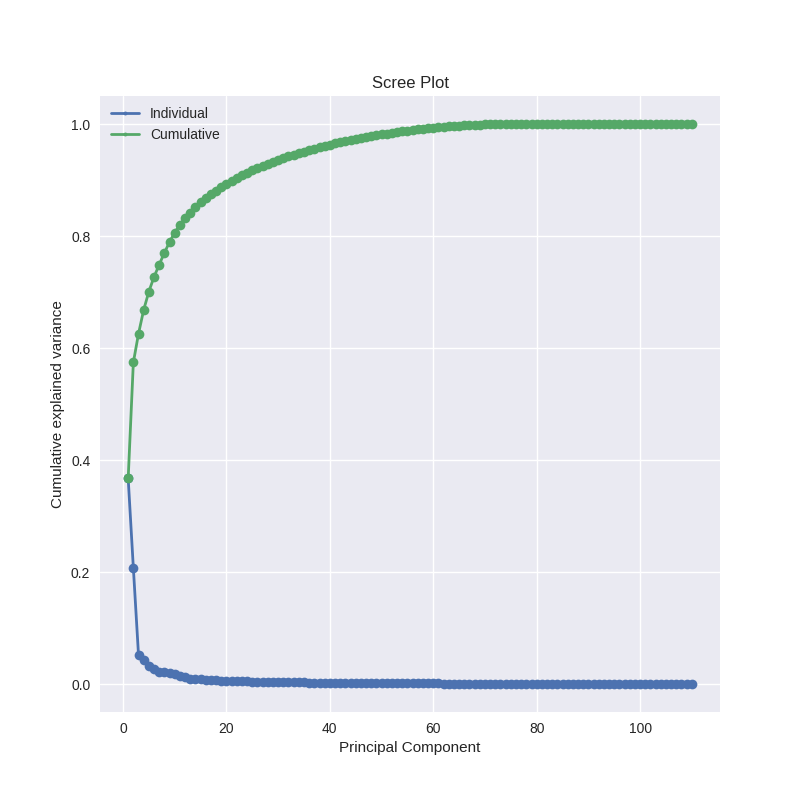

load_node_130    8784
load_node_133    8784
load_node_134    8784
load_node_143    8784
load_node_16     8784
load_node_145    8784
load_node_21     8784
load_node_153    8784
load_node_154    8784
load_node_156    8784
load_node_159    8784
load_node_160    8784
load_node_162    8784
load_node_167    8784
load_node_43     8784
load_node_52     8784
load_node_181    8784
load_node_182    8784
load_node_184    8784
load_node_186    8784
load_node_60     8784
load_node_63     8784
load_node_64     8784
load_node_66     8784
load_node_68     8784
load_node_69     8784
load_node_197    8784
load_node_73     8784
load_node_77     8784
load_node_208    8784
                 ... 
prod_gen_22      3423
prod_gen_23      3512
prod_gen_24         0
prod_gen_25      3533
prod_gen_26         0
prod_gen_27      3294
prod_gen_28         0
prod_gen_29      3220
prod_gen_30      2372
prod_gen_31      3279
prod_gen_32      3398
prod_gen_33      2479
prod_gen_34      3281
prod_gen_35       799
prod_gen_3

In [5]:
from sklearn.decomposition import PCA

# Removal of the time column, as this is not usable in math
datanotime = data_nona.drop('time',1)


# Removing any column where more than 90% of the data is zero
data_notime2 = datanotime.loc[:, (datanotime != 0).sum()>len(datanotime)*.1]

# First we standardize the data
data_stand = (data_notime2 - data_notime2.mean()) / data_notime2.std()

# The standardization created a lot of NaN's
# These came from dividing by zero, as a lot of the prod_gen sensors had only zero's
data_stand = data_stand.dropna(axis='columns',how='all')



print("NaN's in data set: " + str(data_stand.isnull().sum().sum()))
    
# Then instantiate the data, and make the fit
comp=data_stand.shape[1]
pca = PCA(n_components=comp)
pca_data=pca.fit(data_stand)

# Plotting the explained variance
fig = plt.figure(figsize=(8,8))
sing_vals = np.arange(comp) + 1
plt.plot(sing_vals, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')
plt.plot(sing_vals, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2)

plt.legend(['Individual','Cumulative'], loc='best', borderpad=0.3, 
            shadow=False,
            markerscale=0.4)

# Saving the pca components
data_components = pca.components_

#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
print((datanotime != 0).sum())

In [6]:
# Find the number of components needed to explain 90% of the variance
for i in range(0,comp):
    if pca.explained_variance_ratio_.cumsum()[i] >= 0.9:
        print("with " +str(i+1) +" components you explain " + str(pca.explained_variance_ratio_.cumsum()[i]*100) +"%" )
        new_comp=(i+1)
        break;


with 22 components you explain 90.3623534875%


### Scree plot
**Q#4** How many principal components do you need to explain 90 % of the variance

22 pricipal components would be needed to explain more than 90% of the variance

22 components will explain 90.36% of the variance

### Clustering
You want to reduce the amount of field sensors to 20. You should now have from the previous question, an array with all your loading vectors (pca.components\_), one vector per principal component, with 137 elements (one per each sensor). Use clustering to group sensors that behave the same. 

**Q#5** How would you choose which sensors in each cluster you should keep?

*We pick the sensor closest to the cluster center from each of the 20 clusters we make. This should give us a good approximation of the clusters data*

In [7]:
from sklearn.cluster import KMeans

# Slice the components we need. We take 26 as that gives us about 90% explained variance
slice=data_components[0:new_comp]

# Instanciate and fit the clusters
kmeans = KMeans(n_clusters=20, n_init=200, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, n_jobs=2)
kmeans.fit(slice.T)
cluster_pred = kmeans.predict(slice.T)

# Prints the predicted clusters
print(cluster_pred)

[ 3  3  3  3  8  3  8  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  9  5 15  5  7  3  9  5  9 18  5 14 12  5
 14 18  5  4  9  0  5  1 17  2 19  5  2  1 19  1 16  5 19  4 19  5  3  6  6
  6 11 12 11 12 18 12  5 18 17 13  0 10  9  9 14  0 13 14  0  7 13 13 13 14
  7  7 14 10 13  0  0  0 14  9]


In [12]:
import scipy

# Make a pandas dataframe of our sensors, and the clusters they belong to
clust = pd.DataFrame(data_stand.columns, columns=['sensors'])
clust['cluster'] = cluster_pred

# calculate the distance from a sensor to the cluster center
temp = []
for i in range(slice.T.shape[0]):
    A=slice.T[i]
    B=kmeans.cluster_centers_[clust.cluster[i]]
    temp.append(scipy.spatial.distance.euclidean(A, B))
clust['dist_to_center'] = temp

# Find the sensor in a cluster that is closest to the cluster centers
x=0
data_reduced = []
sensor_cluster = []
while x <= max(clust.cluster):
    temp_min = 100000
    temp_ind = 0
    for i in range(slice.shape[1]):
        if clust.cluster[i] == x:
            if clust.dist_to_center[i] < temp_min:
                temp_min = clust.dist_to_center[i]
                temp_ind = i
    data_reduced.append(clust.sensors[temp_ind])
    x+=1

# Make a new pandas dataframe witht the reduced sensor list
data_reduced = pd.DataFrame(data_reduced, columns=['sensors'])

# Sort the list of clusters by their distance to the center, for manual check up
sorted_clust = clust.sort_values(by=['dist_to_center'])

# For manual check
#print(data_reduced.to_string(index=False))
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#    print(sorted_clust)

In [13]:
x=0
index = []
for i in range(data_nona.shape[1]):
       for x in range(data_reduced.sensors.shape[0]):
            if data_reduced.sensors.iloc[x] == data_nona.columns[i]:
                index.append(i)
                x+=1

data_reduced = data_nona[index]     
print(data_reduced.columns)

Index(['load_node_16', 'load_node_98', 'export_node_68', 'export_node_170',
       'export_node_108', 'renew_node_143', 'renew_node_17', 'renew_node_154',
       'renew_node_155', 'renew_node_25', 'renew_node_41', 'renew_node_202',
       'renew_node_86', 'renew_node_99', 'prod_gen_5', 'prod_gen_9',
       'prod_gen_25', 'prod_gen_31', 'prod_gen_34', 'prod_gen_41'],
      dtype='object')


### Save your chosen sensors

Now that you have chosen 20 sensors which are representative of your data, create a DataFrame that contains these sensors. You can save them to csv file using the code in the following cell.

In [10]:
# Assuming of course that your reduced data set is called data_reduced

data_reduced['time']=data_nona['time']
data_reduced.to_csv('reduced_field_data.csv')


/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
